# Cloudbutton Geospatial: Water Consumption Workflow

---

In [ ]:
import sys
sys.path.append('/work')


: 

In [ ]:
import os

os.environ["AWS_ACCESS_KEY_ID"] = "AWS_ACCESS_KEY_ID"
os.environ["AWS_SECRET_ACCESS_KEY"] = "AWS_SECRET_ACCESS_KEY"

In [ ]:
from collections import defaultdict
from cloudbutton_geospatial.io_utils.plot import plot_results
from cloudbutton_geospatial.utils.notebook import date_picker
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from shapely.geometry import Point, MultiPoint, box
from pprint import pprint
import functools
import collections
import datetime
import os
import shutil
import math
import numpy as np
import pandas as pd
import lithops
import requests
import rasterio
import fiona
import json
import random
import re
import tempfile
import concurrent.futures
from IPython.display import Image
import matplotlib.pyplot as plt
from lithops.storage import Storage
from lithops.storage.utils import StorageNoSuchKeyError
from io import BytesIO


from data_cockpit.widget import DataLoaderWidget


## Workflow parameters

Area outside the processed tile that we want to consider for taking SIAM stations into account:

In [4]:
AREA_OF_INFLUENCE = 16000

Lithops Variables:

In [5]:
DATA_BUCKET = 'cloudbutton-wc'
COMPUTE_BACKEND = 'aws_lambda'
STORAGE_BACKEND = 'aws_s3'
STORAGE_PREFIX = 's3://'
RUNTIME_MEMORY = 2048

In [6]:
storage = lithops.storage.Storage(backend=STORAGE_BACKEND)

In [ ]:
data_loader = DataLoaderWidget()

data_loader.display()


In [11]:
chunks = data_loader.get_data_slices()
SPLITS = data_loader.get_batch_size()

In [ ]:
SPLITS

In [ ]:
chunks

In [14]:
DTM_PREFIX = 'DTMs/'
DTM_ASC_PREFIX = 'DTMs/asc/'
DTM_GEOTIFF_PREFIX = 'DTMs/geotiff/'

Split tile into square chunks (number of tiles = SPLITS^2):

Correlation coefficient between elevation and temperature:

In [15]:
r = -0.0056

Elevation to interpolate temperature:

In [16]:
zdet = 2000

Day of year to calculate solar irradiation:

In [17]:
date = date_picker(default=datetime.date(2022, 5, 15))

DatePicker(value=datetime.date(2022, 5, 15), description='Pick a Date', step=1)

In [18]:
DAY_OF_YEAR = date.value.timetuple().tm_yday
DAY_OF_YEAR

135

Initialize Lithops Storage and Function Executor:

In [19]:
fexec = lithops.FunctionExecutor(backend=COMPUTE_BACKEND, storage=STORAGE_BACKEND, runtime_memory=RUNTIME_MEMORY)

2025-03-28 16:50:25,862 [INFO] config.py:146 -- Lithops v3.5.2.dev0 - Python3.10
2025-03-28 16:50:25,863 [DEBUG] config.py:107 -- Loading configuration from the cloud
2025-03-28 16:50:26,140 [DEBUG] config.py:186 -- Loading Serverless backend module: aws_lambda
2025-03-28 16:50:26,145 [DEBUG] config.py:226 -- Loading Storage backend module: aws_s3
2025-03-28 16:50:26,147 [DEBUG] aws_s3.py:36 -- Creating AWS S3 Client
2025-03-28 16:50:26,479 [INFO] aws_s3.py:59 -- S3 client created - Region: us-east-1
2025-03-28 16:50:26,528 [DEBUG] aws_lambda.py:53 -- Creating AWS Lambda client
2025-03-28 16:50:26,739 [INFO] aws_lambda.py:97 -- AWS Lambda client created - Region: us-east-1
2025-03-28 16:50:26,744 [DEBUG] invokers.py:105 -- ExecutorID 83e80c-0 - Invoker initialized. Max workers: 1000
2025-03-28 16:50:26,746 [DEBUG] invokers.py:309 -- ExecutorID 83e80c-0 - Serverless invoker created
2025-03-28 16:50:28,601 [DEBUG] executors.py:164 -- Function executor for aws_lambda created with ID: 83e8

## Data preparation

### SIAM data

In [20]:
siam_data_key = 'siam_data.csv'
try:
    siam_data_head = storage.head_object(bucket=DATA_BUCKET, key=siam_data_key)
    print(f'SIAM meteo data already in storage: {siam_data_head}')
except StorageNoSuchKeyError:
    print('Uploading SIAM meteo data to Object Storage...')
    with open(siam_data_key, 'rb') as f:
        storage.put_object(bucket=DATA_BUCKET, key=siam_data_key, body=f)

SIAM meteo data already in storage: {'x-amz-id-2': 'q6uQegPl5M81y/LRK5Oc1MuavmZ3rAxSWYhoasM6aWXa7BpwK+VuDeyliVmay6tdZEqyQKhf3klLSe53WuqsyA==', 'x-amz-request-id': 'GTP7JAFDP3X4J9FG', 'date': 'Fri, 28 Mar 2025 16:50:30 GMT', 'last-modified': 'Thu, 24 Oct 2024 22:21:09 GMT', 'etag': '"8a1fd5da76b1123e66cc0155e6c8f5f7"', 'x-amz-server-side-encryption': 'AES256', 'accept-ranges': 'bytes', 'content-type': 'binary/octet-stream', 'content-length': '3850', 'server': 'AmazonS3'}


### Shapefile

In [21]:
shapefile_key = 'shapefile_murcia.zip'
try:
    shapefile_head = storage.head_object(bucket=DATA_BUCKET, key=shapefile_key)
    print(f'Shapefile already in storage: {siam_data_head}')
except StorageNoSuchKeyError:
    print('Uploading shapefile to Object Storage...')
    with open(shapefile_key, 'rb') as f:
        storage.put_object(bucket=DATA_BUCKET, key=shapefile_key, body=f)

Shapefile already in storage: {'x-amz-id-2': 'q6uQegPl5M81y/LRK5Oc1MuavmZ3rAxSWYhoasM6aWXa7BpwK+VuDeyliVmay6tdZEqyQKhf3klLSe53WuqsyA==', 'x-amz-request-id': 'GTP7JAFDP3X4J9FG', 'date': 'Fri, 28 Mar 2025 16:50:30 GMT', 'last-modified': 'Thu, 24 Oct 2024 22:21:09 GMT', 'etag': '"8a1fd5da76b1123e66cc0155e6c8f5f7"', 'x-amz-server-side-encryption': 'AES256', 'accept-ranges': 'bytes', 'content-type': 'binary/octet-stream', 'content-length': '3850', 'server': 'AmazonS3'}


### Digital Terrain Models

Download DTM files for free from http://centrodedescargas.cnig.es/CentroDescargas/buscadorCatalogo.do?codFamilia=MDT05# and put them in `input_DTMs` folder.

Find downloaded MDTs:

## Raster Data Interpolation

Split data tiles in subtiles for increased parallelism:

In [22]:
def compute_solar_irradiation(inputFile, outputFile, crs='32630'):
    # Define grass working set
    GRASS_GISDB = '/tmp/grassdata'
    #GRASS_GISDB = 'grassdata'
    GRASS_LOCATION = 'GEOPROCESSING'
    GRASS_MAPSET = 'PERMANENT'
    GRASS_ELEVATIONS_FILENAME = 'ELEVATIONS'

    os.environ['GRASSBIN'] = 'grass76'

    from grass_session import Session
    import grass.script as gscript
    import grass.script.setup as gsetup
    from grass.pygrass.modules.shortcuts import general
    from grass.pygrass.modules.shortcuts import raster
    
    os.environ.update(dict(GRASS_COMPRESS_NULLS='1'))

    # Clean previously processed data
    if os.path.isdir(GRASS_GISDB):
        shutil.rmtree(GRASS_GISDB)
    
    with Session(gisdb=GRASS_GISDB, location=GRASS_LOCATION, mapset=GRASS_MAPSET, create_opts='EPSG:32630') as ses:
        # Set project projection to match elevation raster projection
        general.proj(epsg=crs, flags='c') 
        # Load raster file into working directory
        raster.import_(input=inputFile, output=GRASS_ELEVATIONS_FILENAME, flags='o')    
        
        # Set project region to match raster region
        general.region(raster=GRASS_ELEVATIONS_FILENAME, flags='s')    
        # Calculate solar irradiation
        gscript.run_command('r.slope.aspect', elevation=GRASS_ELEVATIONS_FILENAME,
                            slope='slope', aspect='aspect')
        gscript.run_command('r.sun', elevation=GRASS_ELEVATIONS_FILENAME,
                            slope='slope', aspect='aspect', beam_rad='beam',
                            step=1, day=DAY_OF_YEAR)
        
        # Get extraterrestrial irradiation from history metadata
        regex = re.compile(r'\d+\.\d+')
        output = gscript.read_command("r.info", flags="h", map=["beam"])
        splits = str(output).split('\n')
        line = next(filter(lambda line: 'Extraterrestrial' in line, splits))
        extraterrestrial_irradiance = float(regex.search(line)[0])
        
        # Export generated results into a GeoTiff file
        if os.path.isfile(outputFile):
            os.remove(outputFile)

        raster.out_gdal(input='beam', output=outputFile)
        
        return extraterrestrial_irradiance

Get stations contained in the area of interest:

In [23]:
def filter_stations(bounds, stations):
    total_points = MultiPoint([Point(x, y) for x, y in stations[['X', 'Y']].to_numpy()])
    total_points_list = list(total_points.geoms)
    intersection = bounds.buffer(AREA_OF_INFLUENCE).intersection(total_points)
    filtered_stations = [point for point in total_points_list if intersection.contains(point)]

    return stations[[point in filtered_stations for point in total_points_list]]

Inverse Distance Weighting interpolation:

In [24]:
def compute_basic_interpolation(shape, stations, field_value, offset = (0,0)):
    station_pixels = [[pixel[0], pixel[1]] for pixel in stations['pixel'].to_numpy()]
    
    # Get an array where each position represents pixel coordinates
    tile_pixels = np.indices(shape).transpose(1,2,0).reshape(shape[0]*shape[1], 2) + offset
    dist = distance_matrix(station_pixels, tile_pixels)
    weights = np.where(dist == 0, np.finfo('float32').max, 1.0 / dist )
    weights /=  weights.sum(axis=0)
    
    return np.dot(weights.T, stations[field_value].to_numpy()).reshape(shape).astype('float32')

Interpolate temperatures from a subset of the tile:

In [25]:
def radiation_interpolation(tile_key, block_x, block_y, chunk_cloudobject, storage):
    tile_id, _ = os.path.splitext(tile_key)
    print(tile_id)

    # Write tile chunk to file
    chunk_file = os.path.join(tempfile.gettempdir(), tile_id + str(block_x) + '_' + str(block_y) + '.tif')
    print(chunk_file)

    chunk_cloudobject.to_file(chunk_file)

    with rasterio.open(chunk_file, 'r') as chunk_src:
        profile = chunk_src.profile

    extr_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_extr_' + str(block_x) + '_' + str(block_y) + '.tif')
    rad_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_rad_' + str(block_x) + '_' + str(block_y) + '.tif')

    # Compute solar irradiation from inputFile, creates radiation raster at outputFile
    extraterrestrial_irradiation = compute_solar_irradiation(inputFile=chunk_file, outputFile=rad_chunk_file)

    # Create and store a raster with extraterrestrial irradiation
    with rasterio.open(extr_chunk_file, 'w', **profile) as dest:
        data = np.full((profile['height'], profile['width']), extraterrestrial_irradiation, dtype='float32')
        dest.write(data, 1)

    with open(extr_chunk_file, 'rb') as f:
        extr_co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)

    with open(rad_chunk_file, 'rb') as f:
        rad_co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)

    return [(tile_key, 'extr', block_x, block_y, extr_co), (tile_key, 'rad', block_x, block_y, rad_co)]

In [26]:
def map_interpolation(tile_key, block_x, block_y, chunk_cloudobject, data_field, storage):
    tile_id, _ = os.path.splitext(tile_key)

    # Get SIAM meteo data
    siam_stream = storage.get_object(DATA_BUCKET, siam_data_key, stream=True)
    siam_data = pd.read_csv(siam_stream)

    # print(siam_data)
    chunk_file = os.path.join(tempfile.gettempdir(), f"{tile_id}_{block_x}_{block_y}.tif")
    chunk_cloudobject.to_file(chunk_file)

    # Abre el fichero recién generado
    with rasterio.open(chunk_file, 'r') as chunk_src:
        transform = chunk_src.transform
        profile = chunk_src.profile

        bounding_rect = box(chunk_src.bounds.left, chunk_src.bounds.top, chunk_src.bounds.right, chunk_src.bounds.bottom)
        filtered = pd.DataFrame(filter_stations(bounding_rect, siam_data))
        #print(filtered)

        if filtered.shape[0] == 0:
            return [(tile_key, data_field, block_x, block_y, None)]

        filtered['pixel'] = filtered.apply(lambda station: rasterio.transform.rowcol(transform, station['X'], station['Y']), axis=1)

        # Interpolate variables from meteo station data, generate raster with result
        dest_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_' + data_field + '_' + str(block_x) + '_' + str(block_y) + '.tif')

        with rasterio.open(dest_chunk_file, 'w', **profile) as chunk_dest:
            if data_field == 'temp':
                elevations = chunk_src.read(1)  # Get elevations content
                print(dest_chunk_file)
                interpolation = compute_basic_interpolation(elevations.shape, filtered, 'tdet', (0, 0))
                interpolation += r * (elevations - zdet)
                chunk_dest.write(np.where(elevations == chunk_src.nodata, np.nan, interpolation), 1)
            elif data_field == 'humi':
                interpolation = compute_basic_interpolation((profile['height'], profile['width']), filtered, 'hr', (0, 0))
                chunk_dest.write(interpolation, 1)
            elif data_field == 'wind':
                interpolation = compute_basic_interpolation((profile['height'], profile['width']), filtered, 'v', (0, 0))
                chunk_dest.write(interpolation, 1)
            else:
                raise Exception(f'Unknown data field "{data_field}"')

    # Upload results to storage as Cloudobject
    with open(dest_chunk_file, 'rb') as f:
        co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)

    return [(tile_key, data_field, block_x, block_y, co)]

In [27]:
from typing import List, Tuple


def generate_iterdata(chunks) -> List[Tuple]:
    """Generates the iterdata array with the data blocks extracted from the COG."""
    iterdata = []
    
    for i, window in enumerate(chunks):
        tile_key = window.tile_key
        block_x = window.block_x
        block_y = window.block_y
        chunk_data = window
        print((tile_key, block_x, block_y, chunk_data))

        iterdata.append((tile_key, block_x, block_y, chunk_data))
    
    return iterdata

In [28]:
iterdata = generate_iterdata(chunks)

('PNOA_MDT05_ETRS89_HU30_0997B_LID.tif', 0, 0, <dataplug.formats.geospatial.cog.BlockWindowSlice object at 0x7bc652bc80a0>)
('PNOA_MDT05_ETRS89_HU30_0997B_LID.tif', 0, 1, <dataplug.formats.geospatial.cog.BlockWindowSlice object at 0x7bc652bc81c0>)
('PNOA_MDT05_ETRS89_HU30_0997B_LID.tif', 0, 2, <dataplug.formats.geospatial.cog.BlockWindowSlice object at 0x7bc652bc8190>)
('PNOA_MDT05_ETRS89_HU30_0997B_LID.tif', 1, 0, <dataplug.formats.geospatial.cog.BlockWindowSlice object at 0x7bc652bc8100>)
('PNOA_MDT05_ETRS89_HU30_0997B_LID.tif', 1, 1, <dataplug.formats.geospatial.cog.BlockWindowSlice object at 0x7bc652bc8220>)
('PNOA_MDT05_ETRS89_HU30_0997B_LID.tif', 1, 2, <dataplug.formats.geospatial.cog.BlockWindowSlice object at 0x7bc652bc8250>)
('PNOA_MDT05_ETRS89_HU30_0997B_LID.tif', 2, 0, <dataplug.formats.geospatial.cog.BlockWindowSlice object at 0x7bc652bc81f0>)
('PNOA_MDT05_ETRS89_HU30_0997B_LID.tif', 2, 1, <dataplug.formats.geospatial.cog.BlockWindowSlice object at 0x7bc652bc82b0>)
('PNOA_M

In [29]:
#iterdata

Lithops serverless computation:

In [30]:
res_rad = fexec.map(radiation_interpolation, iterdata, runtime_memory=2048).get_result()
res_temp = fexec.map(map_interpolation, iterdata, extra_args=('temp', ), runtime_memory=2048).get_result()
res_humi = fexec.map(map_interpolation, iterdata, extra_args=('humi', ), runtime_memory=2048).get_result()
res_wind = fexec.map(map_interpolation, iterdata, extra_args=('wind', ), runtime_memory=2048).get_result()

2025-03-28 16:50:30,867 [INFO] invokers.py:119 -- ExecutorID 83e80c-0 | JobID M000 - Selected Runtime: runtime-301b5a47-a1b6-437e-acb9-efc25660660b:fe8d63fd-0eb6-432c-9b82-b58fd81e09eb-amd64 - 2048MB
2025-03-28 16:50:30,870 [DEBUG] storage.py:483 -- Runtime metadata not found in local cache. Retrieving it from storage
2025-03-28 16:50:30,872 [DEBUG] storage.py:487 -- Trying to download runtime metadata from: aws_s3://lithopscloud-bucket-eftk5pvx5np5/lithops.runtimes/aws_lambda/3.5.2.dev0/us-east-1/lithops-worker-f7yr-352dev0-48d2bfee9b.meta.json
2025-03-28 16:50:30,893 [DEBUG] storage.py:509 -- Runtime metadata not found in storage
2025-03-28 16:50:30,895 [INFO] invokers.py:127 -- Runtime runtime-301b5a47-a1b6-437e-acb9-efc25660660b:fe8d63fd-0eb6-432c-9b82-b58fd81e09eb-amd64 with 2048MB is not yet deployed
2025-03-28 16:50:30,896 [INFO] aws_lambda.py:448 -- Deploying runtime: runtime-301b5a47-a1b6-437e-acb9-efc25660660b:fe8d63fd-0eb6-432c-9b82-b58fd81e09eb-amd64 - Memory: 2048 Timeout:

MemoryError: Function exceeded maximum memory and was killed

In [67]:
res_flatten = []
for l in [res_rad, res_temp, res_humi, res_wind]:
    for elem in l:
        for sub_elem in elem:
            res_flatten.append(sub_elem)

In [68]:
# res_flatten

In [69]:
grouped_chunks = collections.defaultdict(list)

for chunk_result in res_flatten:
    tile_key, data_field, block_x, block_y, co = chunk_result
    grouped_chunks[(tile_key, data_field)].append((block_x, block_y, co))

In [70]:
# grouped_chunks

Join split subsets into a tile:

In [ ]:
def merge_blocks(tile_data, chunks, storage):
    from rasterio.windows import Window

    tile_key, data_field = tile_data

    cobjs = [tup[2] for tup in chunks]
    if None in cobjs:
        return None

    # Get width and height from original tile
    tile_base, ext = os.path.splitext(tile_key)
    if ext.lower() != '.tiff':
        tile_key = tile_base + '.tiff'
    source_tile_key = os.path.join(DTM_GEOTIFF_PREFIX, tile_key)
    
    with rasterio.open(BytesIO(storage.get_object(bucket=DATA_BUCKET, key=source_tile_key))) as source_tile:
        height = source_tile.profile['height']
        width = source_tile.profile['width']

    # Open first object to obtain profile metadata
    with rasterio.open(BytesIO(storage.get_cloudobject(chunks[0][2]))) as chunk_src:
        profile = chunk_src.profile
        profile.update(width=width)
        profile.update(height=height)

    # Iterate each object and print its block into the destination file
    merged_file = os.path.join(tempfile.gettempdir(), data_field + '_' + tile_key)
    with rasterio.open(merged_file, 'w', **profile) as dest:
        for chunk in chunks:
            j, i, co = chunk
            with rasterio.open(BytesIO(storage.get_cloudobject(co))) as src:
                step_w = math.floor(width / SPLITS)
                step_h = math.floor(height / SPLITS)
                curr_window = Window(round(step_w * i), round(step_h * j), src.width, src.height)
                content = src.read(1)
                dest.write(content, 1, window=curr_window)

    output_key = os.path.join(DTM_PREFIX, data_field, tile_key)
    with open(merged_file, 'rb') as out_file:
        storage.put_object(bucket=DATA_BUCKET, key=output_key, body=out_file)

    return output_key

Combine previous split subsets:

In [119]:
iterdata = []
for (tile_id, data_field), chunks in grouped_chunks.items():
    iterdata.append(((tile_id, data_field), chunks))

In [120]:
#iterdata

In [121]:
fs_merged = fexec.map(merge_blocks, iterdata, runtime_memory=2048)

2025-03-27 14:47:03,567 [INFO] invokers.py:119 -- ExecutorID 35bfa5-3 | JobID M010 - Selected Runtime: cloudbutton-wc:01 - 2048MB
2025-03-27 14:47:04,083 [INFO] invokers.py:186 -- ExecutorID 35bfa5-3 | JobID M010 - Starting function invocation: merge_blocks() - Total: 5 activations
2025-03-27 14:47:04,401 [ERROR] metrics.py:47 -- Failed to send metric: {"message":"Not Found"}
2025-03-27 14:47:04,703 [ERROR] metrics.py:47 -- Failed to send metric: {"message":"Not Found"}
2025-03-27 14:47:04,705 [INFO] invokers.py:225 -- ExecutorID 35bfa5-3 | JobID M010 - View execution logs at /tmp/lithops-usi/logs/35bfa5-3-M010.log


In [122]:
tiles_merged = fexec.get_result(fs=fs_merged)

2025-03-27 14:47:04,718 [INFO] executors.py:494 -- ExecutorID 35bfa5-3 - Getting results from 5 function activations
2025-03-27 14:47:04,719 [INFO] wait.py:101 -- ExecutorID 35bfa5-3 - Waiting for 5 function activations to complete


    0%|          | 0/5  

2025-03-27 14:47:09,733 [INFO] executors.py:618 -- ExecutorID 35bfa5-3 - Cleaning temporary data


In [123]:
tile_keys_merged = set([os.path.basename(t) for t in tiles_merged])

In [124]:
# tile_keys_merged

## Computation of potential evaporation

In [125]:
def compute_crop_evapotranspiration(temperatures,
                                    humidities,
                                    wind_speeds,
                                    external_radiations,
                                    global_radiations,
                                    KCs):
    gamma = 0.665*101.3/1000
    eSat = 0.6108 * np.exp((17.27*temperatures)/(temperatures+237.3))
    delta = 4098 * eSat / np.power((temperatures + 237.3),2)
    eA = np.where(humidities < 0, 0, eSat * humidities / 100)     # Avoid sqrt of a negative number
    T4 = 4.903 * np.power((273.3 + temperatures),4)/1000000000
    rSrS0 = global_radiations/(external_radiations * 0.75)
    rN = 0.8* global_radiations-T4*(0.34-0.14*np.sqrt(eA))*((1.35*rSrS0)-0.35)
    den = delta + gamma *(1 + 0.34* wind_speeds)
    tRad = 0.408 * delta * rN / den
    tAdv = gamma * (900/(temperatures+273))*wind_speeds * (eSat - eA)/den
    return ((tRad + tAdv) * 7 * KCs).astype('float32')

In [126]:
vineyard = ['VI', 'VO', 'VF', 'FV', 'CV' ]
olive_grove = ['OV', 'VO', 'OF', 'FL', 'OC']
fruit = ['FY', 'VF', 'OF', 'FF', 'CF']
nuts = ['FS', 'FV', 'FL', 'FF', 'CS' ]
citrus = ['CI', 'CV', 'OC', 'CF', 'CS' ]

def get_kc(feature):
    # TODO: Get more precise values of Kc
    print(feature['properties'].keys())
    # sigpac_use = feature['properties']['uso_sigpac']
    sigpac_use = 'FF'
    if sigpac_use in vineyard:
        # Grapes for wine - 0.3, 0.7, 0.45
        return 0.7  
    if sigpac_use in olive_grove:
        # Olive grove - ini: 0.65, med: 0.7, end: 0.7
        return 0.7 
    if sigpac_use in fruit:
        # Apples, Cherries, Pears - 0.45, 0.95, 0.7
        return 0.95
    if sigpac_use in nuts:
        # Almonds - 0.4, 0.9, 0.65
        return 0.9
    if sigpac_use in citrus:
        # Citrus, without ground coverage - 0.7, 0.65, 0.7
        return 0.65
    
    return None

In [127]:
def get_geometry_window(src, geom_bounds):
    left, bottom, right, top = geom_bounds
    src_left, src_bottom, src_right, src_top = src.bounds
    window = src.window(max(left,src_left), max(bottom,src_bottom), min(right,src_right), min(top,src_top))
    window_floored = window.round_offsets(op='floor', pixel_precision=3)
    w = math.ceil(window.width + window.col_off - window_floored.col_off)
    h = math.ceil(window.height + window.row_off - window_floored.row_off)
    return Window(window_floored.col_off, window_floored.row_off, w, h)     

In [128]:
def compute_evapotranspiration_by_shape(tem, hum, win, rad, extrad, dst):

    import fiona
    from shapely.geometry import shape, box
    from rasterio import features

    non_arable_land = ['AG', 'CA', 'ED', 'FO', 'IM', 'PA', 'PR', 'ZU', 'ZV']

    #with fiona.open('zip://home/docker/shape.zip') as shape_src:
    with fiona.open('zip:///tmp/shape.zip') as shape_src:
        for feature in shape_src.filter(bbox=tem.bounds):
            KC = get_kc(feature)
            if KC is not None:
                geom = shape(feature['geometry'])
                window = get_geometry_window(tem, geom.bounds)
                win_transform = rasterio.windows.transform(window, tem.transform)
                # Convert shape to raster matrix
                image = features.rasterize([geom],
                                           out_shape=(window.height, window.width),
                                           transform = win_transform,
                                           fill = 0,
                                           default_value = 1).astype('bool')
                # Get values to compute evapotranspiration
                temperatures = tem.read(1, window=window)
                humidities = hum.read(1, window=window)
                wind_speeds = win.read(1, window=window)
                # Convert from W to MJ (0.0036)
                global_radiations = rad.read(1, window=window) * 0.0036
                external_radiations = extrad.read(1, window=window) * 0.0036
                KCs = np.full(temperatures.shape, KC)
                # TODO: compute external radiation
                #external_radiations = np.full(temperatures.shape, 14)
                # TODO: compute global radiation
                # global_radiations = np.full(temperatures.shape, 10)
                etc = compute_crop_evapotranspiration(
                        temperatures,
                        humidities,
                        wind_speeds,
                        external_radiations,
                        global_radiations,
                        KCs
                )
                etc[temperatures == tem.nodata] = dst.nodata
                etc[np.logical_not(image)] = dst.nodata
                dst.write(etc + dst.read(1, window=window), 1, window=window)

In [129]:
def compute_global_evapotranspiration(tem, hum, win, rad, extrad, dst):    
    for ji, window in tem.block_windows(1):
        bounds = rasterio.windows.bounds(window, tem.transform)
        temperatures = tem.read(1, window=window)
        humidities = hum.read(1, window=window)
        wind_speeds = win.read(1, window=window)
         # Convert from W to MJ (0.0036)
        global_radiations = rad.read(1, window=window) * 0.0036
        external_radiations = extrad.read(1, window=window) * 0.0036
        # TODO: compute external radiation
        #external_radiations = np.full(temperatures.shape, 14)
        # TODO: compute global radiation
        # global_radiations = np.full(temperatures.shape, 10)
        # TODO: compute KCs
        KCs = np.full(temperatures.shape, 1)
        etc = compute_crop_evapotranspiration(
                temperatures,
                humidities,
                wind_speeds,
                external_radiations,
                global_radiations,
                KCs
        )
        dst.write(np.where(temperatures == tem.nodata, dst.nodata, etc), 1, window=window)

In [130]:
def combine_calculations(tile_key, storage):
    from functools import partial
      
    # Download shapefile
    shapefile = storage.get_object(bucket=DATA_BUCKET, key='shapefile_murcia.zip', stream=True)

    with open('/tmp/shape.zip', 'wb') as shapf:
        for chunk in iter(partial(shapefile.read, 200 * 1024 * 1024), ''):
            if not chunk:
                break
            shapf.write(chunk)
    try:
        temp = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'temp', tile_key))
        humi = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'humi', tile_key))
        rad = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'rad', tile_key))
        extrad = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'extr', tile_key))
        wind = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'wind', tile_key))
    except StorageNoSuchKeyError:
        print("Storage error")
        return None
    
    output_file = os.path.join(tempfile.gettempdir(), 'eva' + '_' + tile_key)
    with rasterio.open(BytesIO(temp)) as temp_raster:
        with rasterio.open(BytesIO(humi)) as humi_raster:
            with rasterio.open(BytesIO(rad)) as rad_raster:
                with rasterio.open(BytesIO(extrad)) as extrad_raster:
                    with rasterio.open(BytesIO(wind)) as wind_raster:
                        profile = temp_raster.profile
                        profile.update(nodata=0)
                        with rasterio.open(output_file, 'w+', **profile) as dst:
#                             compute_global_evapotranspiration(temp_raster, humi_raster, wind_raster,
#                                                               rad_raster, extrad_raster, dst)
                            compute_evapotranspiration_by_shape(temp_raster, humi_raster, wind_raster,
                                                                rad_raster, extrad_raster, dst)
    
    output_key = os.path.join(DTM_PREFIX, 'eva', tile_key)
    with open(output_file, 'rb') as output_f:
        storage.put_object(bucket=DATA_BUCKET, key=output_key, body=output_f)
    return output_key

In [131]:
fs_eva = fexec.map(combine_calculations, tile_keys_merged, runtime_memory=2048)
res_eva = fexec.get_result(fs=fs_eva)

2025-03-27 14:47:09,826 [INFO] invokers.py:119 -- ExecutorID 35bfa5-3 | JobID M011 - Selected Runtime: cloudbutton-wc:01 - 2048MB
2025-03-27 14:47:09,831 [INFO] invokers.py:186 -- ExecutorID 35bfa5-3 | JobID M011 - Starting function invocation: combine_calculations() - Total: 1 activations
2025-03-27 14:47:10,142 [ERROR] metrics.py:47 -- Failed to send metric: {"message":"Not Found"}
2025-03-27 14:47:10,462 [ERROR] metrics.py:47 -- Failed to send metric: {"message":"Not Found"}
2025-03-27 14:47:10,464 [INFO] invokers.py:225 -- ExecutorID 35bfa5-3 | JobID M011 - View execution logs at /tmp/lithops-usi/logs/35bfa5-3-M011.log
2025-03-27 14:47:10,465 [INFO] executors.py:494 -- ExecutorID 35bfa5-3 - Getting results from 1 function activations
2025-03-27 14:47:10,466 [INFO] wait.py:101 -- ExecutorID 35bfa5-3 - Waiting for 1 function activations to complete


    0%|          | 0/1  

2025-03-27 14:47:19,484 [INFO] executors.py:618 -- ExecutorID 35bfa5-3 - Cleaning temporary data


In [132]:
res_eva

['DTMs/eva/PNOA_MDT05_ETRS89_HU30_0997B_LID.tiff']

---

In [133]:
fexec.clean(clean_cloudobjects=True)

In [134]:
fexec.job_summary()

2025-03-27 14:47:19,541 [WARNING] executors.py:710 -- Could not log job: aws_lambda backend isn't supported by this function.


---

## Visualization of results

In [135]:
%matplotlib inline


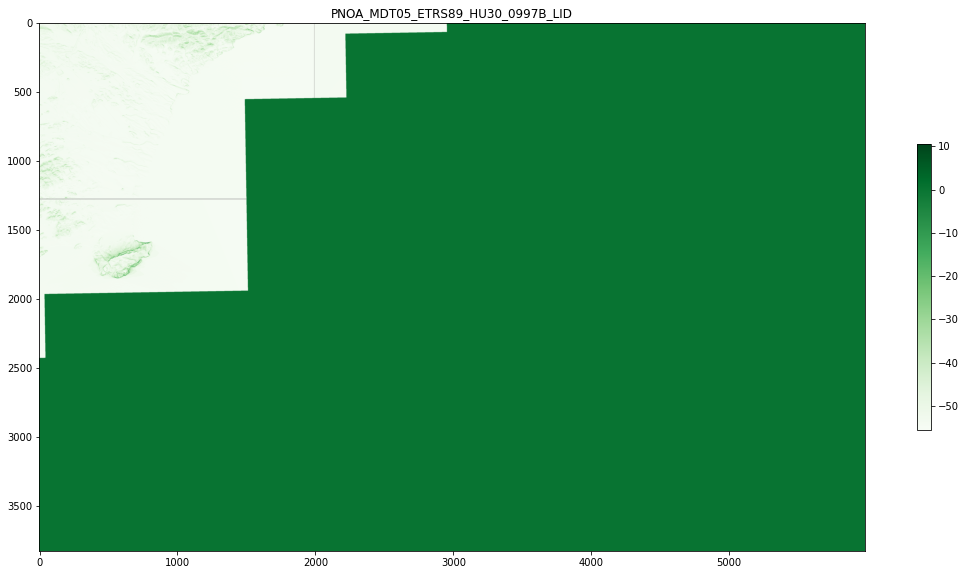

In [136]:
from matplotlib import pyplot as plt

tile = res_eva[0]
tile_key = os.path.basename(tile)
tile_id, _ = os.path.splitext(tile_key)
fig, ax = plt.subplots()

with rasterio.open(BytesIO(storage.get_object(bucket=DATA_BUCKET, key=tile))) as src:
    arr = src.read(1, out_shape=(src.height, src.width))
    ax.set_title(tile_id)
    img = ax.imshow(arr, cmap='Greens')
    fig.colorbar(img, shrink=0.5)

fig.set_size_inches(18.5, 10.5)
plt.show()

# obj.seek(0)

---